In [1]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from xml.dom import minidom
from matplotlib.pyplot import imshow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import scipy.io
import numpy as np
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
batch_size=64##This parameter should Be set according to your GPU/CPU capacity . Else Be Ready FOr Exhaust Error!
num_classes = 120
image_size = 224
num_channels = 3

In [3]:
!pip install split-folders

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/kaggle/input/croppedstanforddataset/cropped", output="output",seed=1337, ratio=(.6, .3,.1), group_prefix=None, move=False) # default values



Copying files: 20578 files [01:23, 247.74 files/s]


In [7]:
# Do we have access to a GPU? Sanity Check
device_list = tf.config.list_physical_devices()
if "GPU" in [device.device_type for device in device_list]:
  print(f"[INFO] TensorFlow has GPU available to use. Woohoo!! Computing will be sped up!")
  print(f"[INFO] Accessible devices:\n{device_list}")
else:
  print(f"[INFO] TensorFlow does not have GPU available to use. Models may take a while to train.")
  print(f"[INFO] Accessible devices:\n{device_list}")

[INFO] TensorFlow has GPU available to use. Woohoo!! Computing will be sped up!
[INFO] Accessible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [9]:
import os
path = "/kaggle/input/croppedstanforddataset/cropped"
len(os.listdir(path))

120

In [10]:
train_dir = '/kaggle/working/output/train'
test_dir = '/kaggle/working/output/test'
val_dir = '/kaggle/working/output/val'
train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    )

# Validation/Test data generator without augmentation
valid_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )
test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
)

# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
)

# Create test generator
test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 12307 images belonging to 120 classes.
Found 6122 images belonging to 120 classes.
Found 2149 images belonging to 120 classes.


In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Model, Sequential
base_model=VGG16(weights='imagenet',include_top=False, input_shape=(224,224,3))
x = base_model.output
x = Flatten()(x)
x = Dropout(0.4)(x)
# let's add two fully-connected layer
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
# and a softmax layer -- let's say we have 200 classes
predictions = Dense(120, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │    51,382,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 70,555,576 (269.15 MB)

 Trainable params: 55,832,696 (212.98 MB)

 Non-trainable params: 14,722,880 (56.16 MB)

None


In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
#from tensorflow.keras.optimizers import Adam,SGD
checkpoint = ModelCheckpoint(
    './base.model.keras',
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=5,
    verbose=1,
    mode='auto'
)
reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    mode='auto'
)

In [14]:
history = model.fit(
        train_generator,
        epochs=25,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystop]
    )

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733238120.208309     132 service.cc:145] XLA service 0x7ed9fc001be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733238120.208362     132 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733238120.208366     132 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733238146.870682     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.0999 - loss: 4.5697
Epoch 1: val_loss improved from inf to 1.80402, saving model to ./base.model.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.1004 - loss: 4.5651 - val_accuracy: 0.5157 - val_loss: 1.8040
Epoch 2/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.4357 - loss: 2.1199
Epoch 2: val_loss improved from 1.80402 to 1.31294, saving model to ./base.model.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.4358 - loss: 2.1192 - val_accuracy: 0.6199 - val_loss: 1.3129
Epoch 3/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.5545 - loss: 1.5352
Epoch 3: val_loss improved from 1.31294 to 1.15534, saving model to ./base.model.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.5546 - loss: 1.5350 - val_accuracy: 0.6612 - val_loss: 1.1553
Epoch 4/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.6140 - loss: 1.2976
Epoch 4: val_loss improved from 1.15534 to 1.064

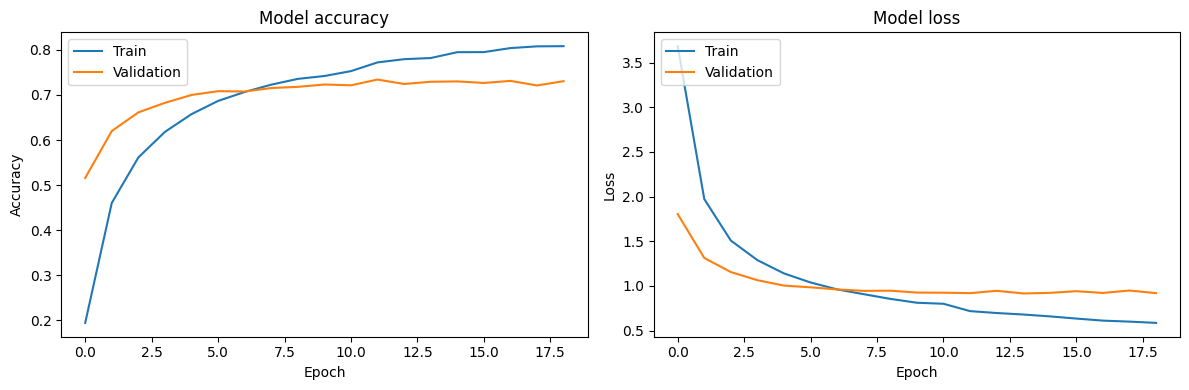

In [15]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 799ms/step - accuracy: 0.7826 - loss: 0.8088
Test Accuracy: 77.66%
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step


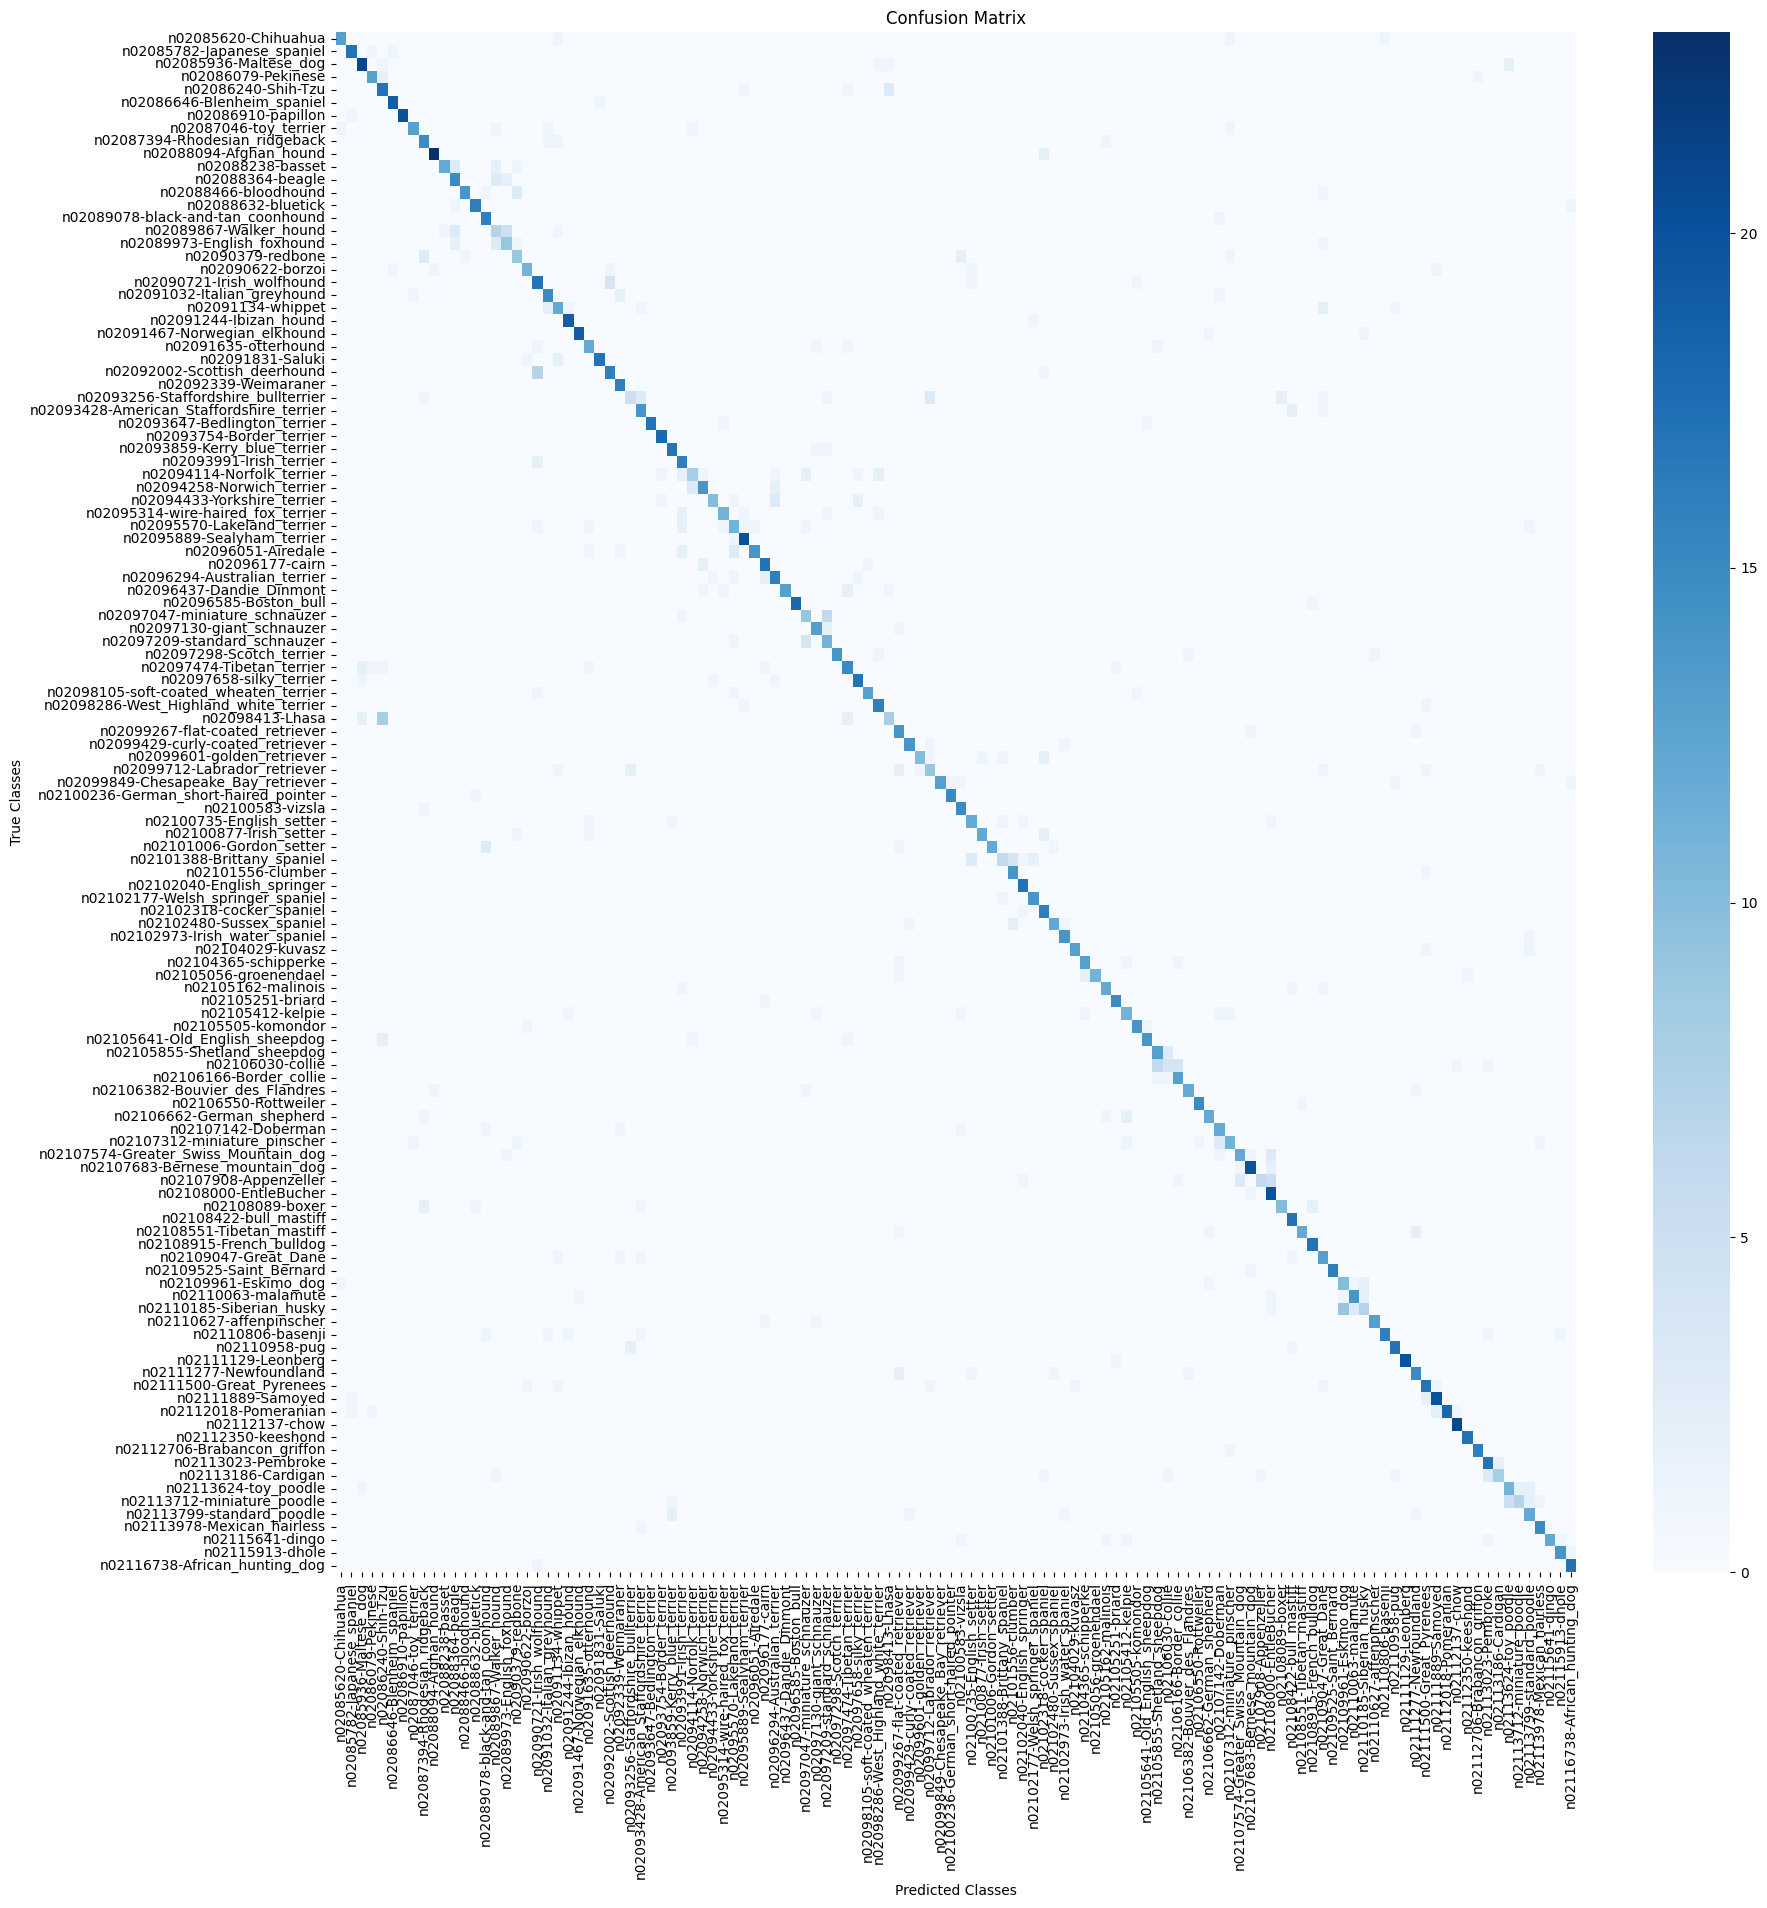

                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.87      0.81      0.84        16
              n02085782-Japanese_spaniel       0.85      0.89      0.87        19
                   n02085936-Maltese_dog       0.78      0.81      0.79        26
                      n02086079-Pekinese       0.81      0.81      0.81        16
                      n02086240-Shih-Tzu       0.55      0.77      0.64        22
              n02086646-Blenheim_spaniel       0.90      0.95      0.93        20
                      n02086910-papillon       1.00      0.95      0.98        21
                   n02087046-toy_terrier       0.87      0.72      0.79        18
           n02087394-Rhodesian_ridgeback       0.65      0.83      0.73        18
                  n02088094-Afghan_hound       0.92      0.92      0.92        25
                        n02088238-basset       0.92      0.67      0.77        18
               

In [16]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predictions and confusion matrix
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_names = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step


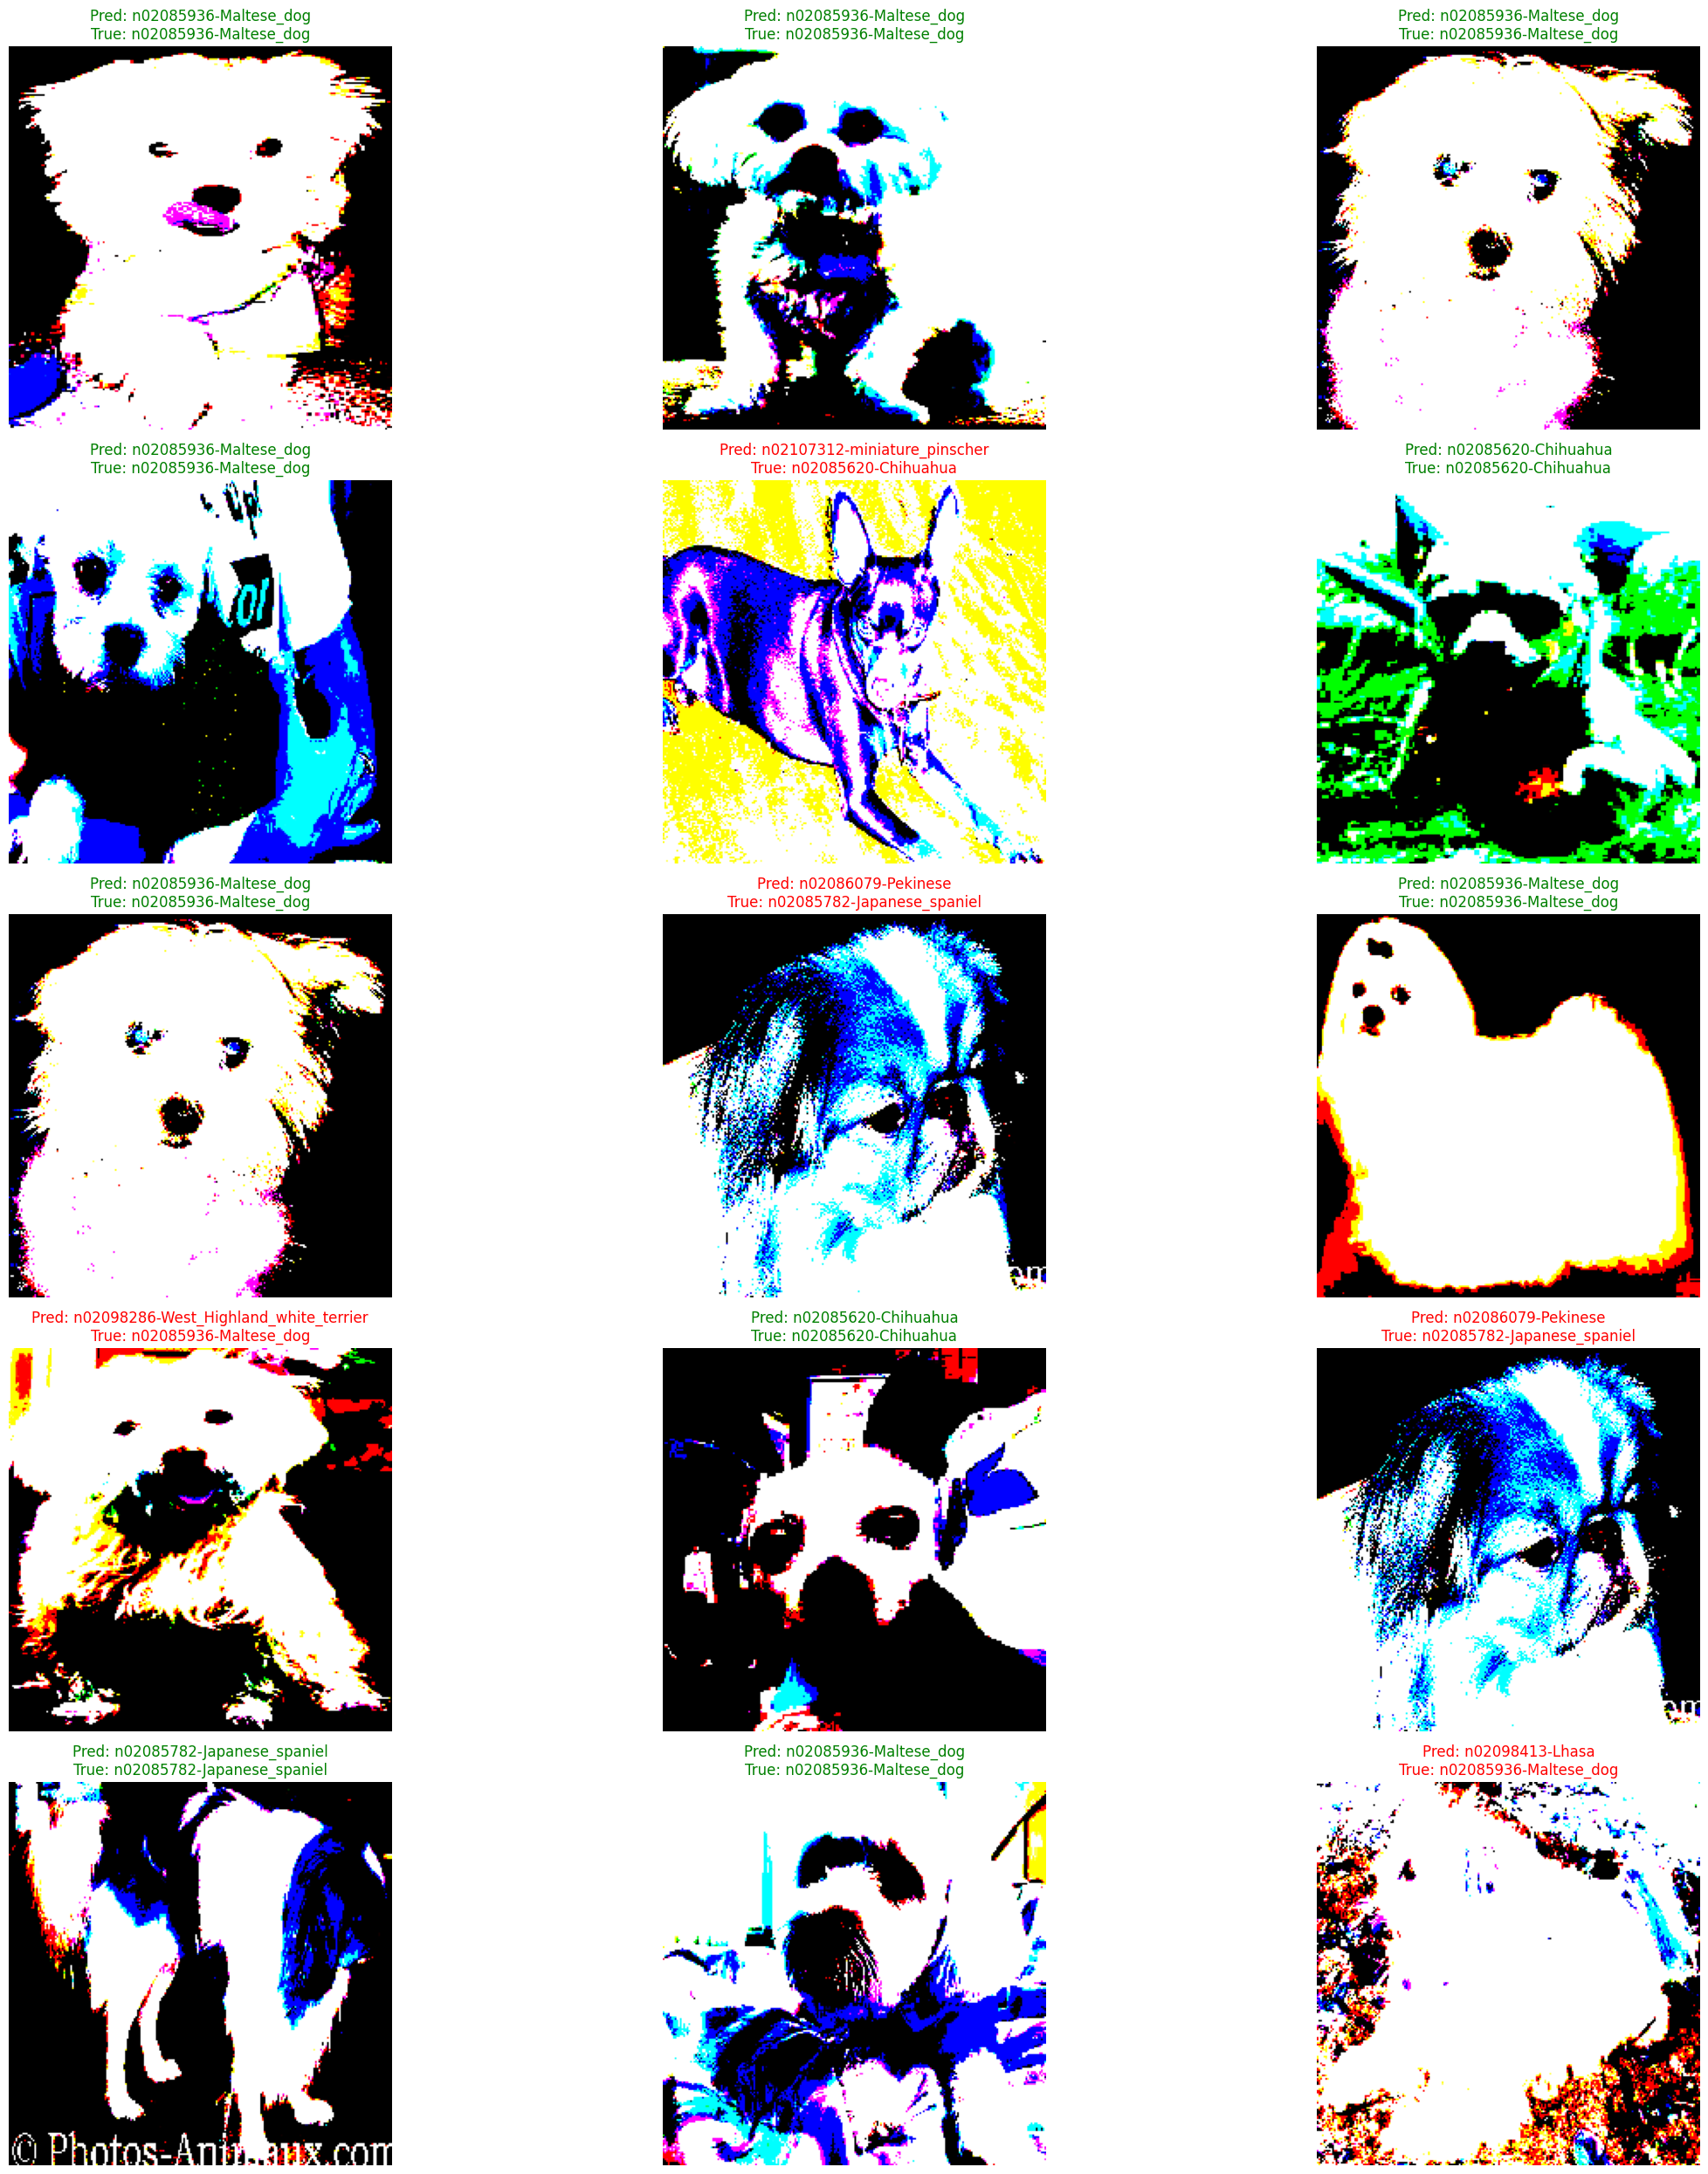

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Set rows, cols for the grid
rows, cols = 5, 3
size = 25

# Get a batch of images and labels from the test generator
X_test, y_test = next(test_generator)  # Retrieve one batch of test data
y_true = np.argmax(y_test, axis=1)  # Convert one-hot to class indices

# Predict the labels for the batch
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Class names
class_names = list(test_generator.class_indices.keys())

# Create a figure for visualization
fig, ax = plt.subplots(rows, cols)
fig.set_size_inches(size, size)

# Plot the images in a grid with predicted and true labels
for i in range(rows):
    for j in range(cols):
        index = np.random.randint(0, len(X_test))  # Randomly select an image from the batch
        img = X_test[index]
        true_label = class_names[y_true[index]]
        pred_label = class_names[y_pred_classes[index]]

        # Display the image
        ax[i, j].imshow(img)
        ax[i, j].axis('off')  # Remove axes for better visualization

        # Set the title with predicted and true labels
        color = 'green' if true_label == pred_label else 'red'
        ax[i, j].set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


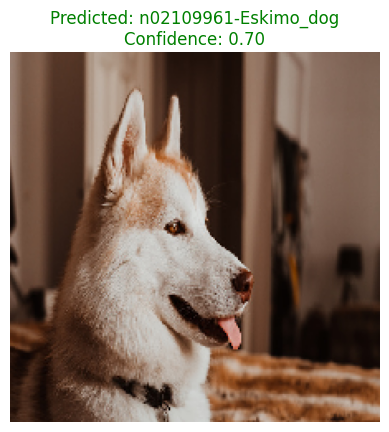

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


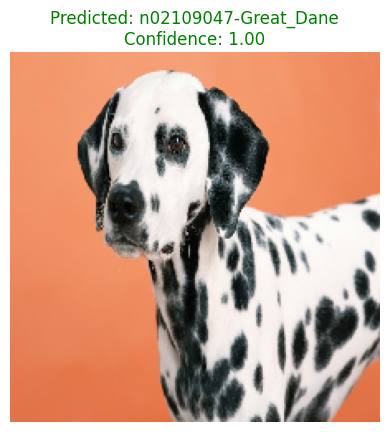

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


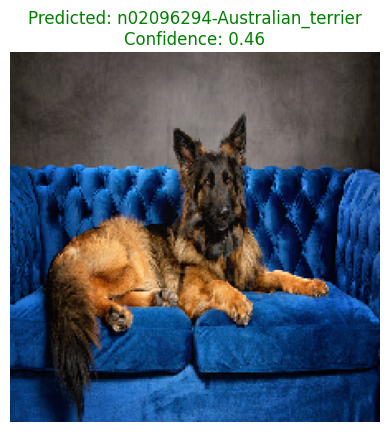

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


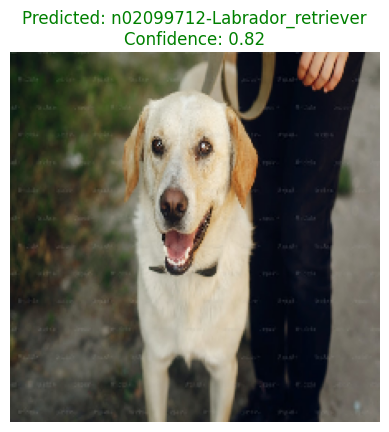

In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def test_single_image(img_path, model, class_names):
    """
    Tests a single image using the trained model and displays the predicted label.

    Args:
        img_path (str): Path to the image file.
        model (keras.Model): Trained model.
        class_names (list): List of class names.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to model's input size
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess using the same function as training

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]  # Get the predicted class name
    confidence = np.max(prediction)  # Confidence score

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}", color='green')
    plt.show()

# Example usage
class_names = list(test_generator.class_indices.keys())  # Get class names from the test generator
test_image_path = '/kaggle/input/dog-breeds/dog-breeds/husky/husky10.jpg'  # Replace with the path to your test image
test_single_image(test_image_path, model, class_names)

test_single_image('/kaggle/input/dog-breeds/dog-breeds/dalmatian/dalmatian16.jpg', model, class_names)
test_single_image('/kaggle/input/dog-breeds/dog-breeds/german-shepherd/german-shepherd107.jpg', model, class_names)
test_single_image('/kaggle/input/dog-breeds/dog-breeds/labrador-retriever/labrador-retriever46.jpg', model, class_names)